In [3]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('model.vec', binary=False)
model.most_similar(positive=['日本'])

[('日本国内', 0.6301000118255615),
 ('アメリカ', 0.571485698223114),
 ('韓国', 0.5515788793563843),
 ('日本の歴史', 0.5300577878952026),
 ('日本国', 0.5054277181625366),
 ('日本の経済史', 0.5011717081069946),
 ('日本の魚', 0.4976142942905426),
 ('米国', 0.4971674680709839),
 ('中国', 0.49715349078178406),
 ('アメリカ合衆国', 0.49622151255607605)]

In [49]:
import glob
import os
from random import shuffle
import random

def pre_process_data(filepath):
    dataset = []
    dirs = []
    
    for dir in os.listdir(filepath):
        if os.path.isdir(filepath + dir):
            dirs.append(filepath + dir)
            
    for i, dir_path in enumerate(dirs):
        dir_name = dir_path.split('/')[-1]
        label_id = i
        print('label_id: {}, dir_name: {}'.format(label_id, dir_name))
        
        for filename in glob.glob(os.path.join(filepath, dir_name, dir_name + "*.txt")):
            with open(filename, 'r' ,encoding="utf-8") as f:
                #datasets hold sets of tuples such as (label, input text)
                dataset.append((label_id, f.read()))
                
    random.seed(1234)            
    shuffle(dataset)
    
    return dataset

In [55]:
path = "livedoor_data/text/"

dataset = pre_process_data(path)
dataset[1234]

(1,
 'http://news.livedoor.com/article/detail/6607699/\n2012-05-30T09:00:00+0900\n斬新なアート表現と生命力！フィリピンの「今」が見られる「The Hope & The Dream in Filipino - Section III」\nフィリピン共和国は、太平洋に浮かぶルソン島、ミンダナオ島やセブ島といった約7000の島からなる群島国家ながら国土は日本の約80％におよび、人口は9400万人が暮らしている。\n\n民族構成はマレー人が中心だが、スペインや米国の植民地支配の影響を強く受けたために、東南アジアでは唯一のキリスト教の信者が圧倒的に多い国でもある。\n\n日本にとっても歴史的な繋がりが深い割に、よく知られていないフィリピン共和国の「今」をとらえた写真展\u3000アジアの写真家たち2012 フィリピン「The Hope & The Dream in Filipino - Section III」が、東京・銀座にあるリコーフォトギャラリーRING CUBEにおいて、本日、2012年5月30日より開催した。\n\n\n今回の写真展は、日本写真協会主催「東京写真月間2012」の一環として、アジアの写真家として、フィリピン共和国の写真家の作品が展示されている。\n\n■斬新なアート感覚を写真の世界へ\n今回のRING CUBEでの展示は、「The Dream ＆ The Hope of Filipino−Section I」から「Section IV」と題して12名の写真家による「フィリピン展」の１つで、都内4か所のギャラリーで開催される。\n\n写真展では、都市開発の裏側で貧困をものともせず前向きに生活する人々の様子や宗教行事への熱狂ぶりが紹介される一方、斬新なアート感覚を写真の世界へ大胆に取り入れた表現など、フィリピン写真界と写真作家の今を紹介する。\n\n\n \n \n\n\nリコーフォトギャラリーRING CUBEの「The Hope & The Dream in Filipino - Section III」では、ジェロイ・マリガヤ・コンセプション氏、ワウィ・ナバローザ氏、フランキー・カラハン氏、3名の作品が展示される。\n\n \n \n\n\n■東京写真月間について\n「

In [51]:
len(dataset)

7367

In [57]:
model["日本"].shape

(300,)

In [106]:
import MeCab

def tokenize_and_vectorize(dataset):
    vectorized_data = []
    tokenizer = MeCab.Tagger("-Owakati -d /var/lib/mecab/dic/mecab-ipadic-neologd")
    for sample in dataset:
        tokens_list = tokenizer.parse(sample[1]).split()
        each_sample_input_vecs = []
        for token in tokens_list:
            try:
                each_sample_input_vecs.append(model[token])
            except KeyError:
                pass
            
        vectorized_data.append(each_sample_input_vecs)
        
    return vectorized_data

In [293]:
def collect_labels(dataset):
    labels = []
    for sample in dataset:
        labels.append(sample[0])
    
    return labels

In [294]:
vectorized_inputs = tokenize_and_vectorize(dataset)
labels = collect_labels(dataset)

TypeError: 'Sequential' object is not subscriptable

In [295]:
len(vectorized_inputs[0])

512

In [296]:
len(vectorized_inputs)

7367

In [297]:
len(vectorized_inputs[0][0])

300

In [298]:
len(labels)

7367

In [299]:
split_data = int(len(vectorized_inputs)* 0.8)

x_train = vectorized_inputs[:split_data]
x_test = vectorized_inputs[split_data:]
y_train= labels[:split_data]
y_test = labels[split_data:]

In [300]:
max = 0

for elem in vectorized_inputs:
    if len(elem) > max:
        max = len(elem)
        
print(max)

5760


In [336]:
max_len = 512
batch_size = 32
embedding_dims = 300
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 10

In [302]:
from tqdm import tqdm

def pad_or_truncate_inputs(data, max_len):
    new_data = []
    pad_vec = []
    for _ in range(len(data[0][0])):
        pad_vec.append(0.0)
        
    print('len of pad_vec:', len(pad_vec))
        
    for sample in tqdm(data):
        if len(sample) >= max_len:
            tmp = sample[:max_len]
        else:
            tmp = sample
            num_of_pad_vecs_needed = max_len - len(sample)
            for _ in range(num_of_pad_vecs_needed):
                tmp.append(pad_vec)
                
        new_data.append(tmp)
        
    return new_data

In [303]:
import numpy as np

x_train = pad_or_truncate_inputs(x_train, max_len)
x_test = pad_or_truncate_inputs(x_test, max_len)
x_train = np.reshape(x_train, (len(x_train), max_len, embedding_dims))
x_test = np.reshape(x_test, (len(x_test), max_len, embedding_dims))

100%|██████████| 1474/1474 [00:00<00:00, 66071.09it/s]

len of pad_vec: 300
len of pad_vec: 300


In [304]:
from keras.utils.np_utils import to_categorical

y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train.astype('int32'), 9)
y_test = to_categorical(y_test.astype('int32'), 9)

In [305]:
y_train.shape

(5893, 9)

In [306]:
y_test.shape

(1474, 9)

In [337]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Conv1D(filters,
                kernel_size,
                padding='valid',
                activation='relu',
                strides=1,
                input_shape=(max_len, embedding_dims)
                ))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, 
                activation='relu'
               ))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [338]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 510, 256)          230656    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 2313      
Total params: 298,761
Trainable params: 298,761
Non-trainable params: 0
_________________________________________________________________


In [339]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [340]:
hist = model.fit(x_train,
                 y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/10
5893/5893 [==============================] - 5s 785us/step - loss: 0.9879 - acc: 0.6744 - val_loss: 0.3465 - val_acc: 0.8908
Epoch 2/10
5893/5893 [==============================] - 3s 575us/step - loss: 0.2978 - acc: 0.9116 - val_loss: 0.2280 - val_acc: 0.9274
Epoch 3/10
5893/5893 [==============================] - 3s 578us/step - loss: 0.1536 - acc: 0.9549 - val_loss: 0.1761 - val_acc: 0.9457
Epoch 4/10
5893/5893 [==============================] - 3s 577us/step - loss: 0.0821 - acc: 0.9764 - val_loss: 0.1516 - val_acc: 0.9484
Epoch 5/10
5893/5893 [==============================] - 3s 580us/step - loss: 0.0420 - acc: 0.9908 - val_loss: 0.1824 - val_acc: 0.9464
Epoch 6/10
5893/5893 [==============================] - 3s 573us/step - loss: 0.0265 - acc: 0.9937 - val_loss: 0.1569 - val_acc: 0.9518
Epoch 7/10
5893/5893 [==============================] - 3s 578us/step - loss: 0.0168 - acc: 0.9958 - val_loss: 0.1722 - val_acc: 0.9512


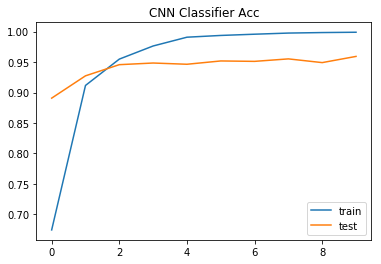

In [341]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

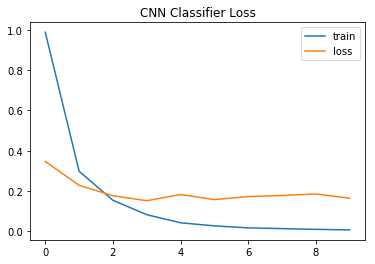

In [342]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.legend(['train', 'loss'], loc='upper right')
plt.show()

In [350]:
pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)

y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: [0 2 2 ... 1 4 7]


In [357]:
from sklearn.metrics import classification_report, confusion_matrix

result = classification_report(y_test, pred_values, digits=3)

print('【labels】0:')
print(result)

【labels】0:
              precision    recall  f1-score   support

           0      0.932     0.937     0.934       175
           1      0.945     1.000     0.972       154
           2      1.000     0.964     0.982       167
           3      0.931     0.825     0.874       114
           4      0.930     1.000     0.964       174
           5      0.944     0.908     0.925       184
           6      0.979     0.989     0.984       186
           7      0.982     1.000     0.991       163
           8      0.987     0.975     0.981       157

   micro avg      0.959     0.959     0.959      1474
   macro avg      0.959     0.955     0.956      1474
weighted avg      0.959     0.959     0.959      1474



In [352]:
confusion_matrix(y_test, pred_values)

array([[164,   0,   0,   4,   2,   4,   0,   0,   1],
       [  0, 154,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1, 161,   1,   1,   2,   1,   0,   0],
       [  2,   5,   0,  94,   6,   4,   1,   1,   1],
       [  0,   0,   0,   0, 174,   0,   0,   0,   0],
       [  9,   1,   0,   1,   4, 167,   1,   1,   0],
       [  0,   2,   0,   0,   0,   0, 184,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 163,   0],
       [  1,   0,   0,   1,   0,   0,   1,   1, 153]])

(1474, 9)